In [1]:
import sys
sys.path.insert(1, '/Users/mac/Desktop/PycharmProjects/TAADL/src')
sys.path.insert(2, '/Users/mac/Desktop/PycharmProjects/TAADL/models')

In [75]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from typing import Optional
from strategy import RiskParity
from network import GPCopulaRNN
from utils import load_data, train_test_split

# Data Preprocessing

In [3]:
# load and preprocess the data
prices_d, prices_m = load_data()
Z_tr, Z_te, X_tr, X_te, cdf = train_test_split(prices_m)

In [134]:
from scipy.optimize import minimize, Bounds, LinearConstraint


class RiskParity:
    def __init__(self, data:pd.DataFrame, bound:list = [0, np.inf]):
        self.data = {}
        self.data["price"] = data
        self.data["lret"]  = np.log(data/data.shift(1)).fillna(0)
        self.data["rv"]    = self.data["lret"].add(1)
        self.num_assets = self.data["price"].shape[1]

        # portoflio weight and performance dataframes which are to be filled.
        self.allocation   = pd.DataFrame(index=self.data["price"].index, columns=self.data["price"].columns)
        self.equity_curve = pd.DataFrame(index=self.data["price"].index, columns=['Risk_Parity']) # cumulative return
        
        # Optimization constraints
        self.bounds = Bounds([bound[0]]*self.num_assets, [bound[1]]*self.num_assets)  # 모든 weight 의 lower limit 부여. Default: 0 <= x
        self.constraint = LinearConstraint([[1]*self.num_assets], [1], [1])  # 모든 weight 의 합은 1 이라는 조건 부여
  
    def obj_func(self, w: np.ndarray, cov: np.ndarray, b:np.ndarray):
        sigma = np.sqrt(w.T @ cov @ w)
        x = w/sigma
        return np.sum(abs((cov @ x) * x - b))
        
    def calc_weight(self, cov: np.ndarray, b:Optional[np.ndarray]=None) -> np.array:
        # define initial weight to optimize
        if b is None:
            b = np.repeat([1/self.num_assets], self.num_assets) # 1/N
        init_w = np.array([1/self.num_assets] * self.num_assets)
        result = minimize(fun=self.obj_func, method='SLSQP', x0=init_w, args=(cov, b), bounds=self.bounds, constraints=self.constraint, options ={'ftol':1e-8}) # minimize port. variance
        return result['x'] #normalize the weight

    def run(self):
        """
        note that this strategy performs rebalancing once per month. (end of the month.)
        Hence we select monthly frequency.
        """
        # calculate portfolio weight first.
        lret = self.data['lret']
        months = pd.unique(lret.index.strftime('%Y-%m')) # a list containing values as 'yyyy-mm' format e.g '2019-01'

        for idx in range(6,len(months)):
            start_month = months[idx-6] 
            end_month   = months[idx-1] 
            this_month  = months[idx]

            # using the daily return data of the last month, update weight this month
            cov = lret.loc[start_month:end_month,:].cov().values
            weight = self.calc_weight(cov)
            self.allocation.loc[this_month,:] = weight.T
        
    def performance(self):
        """
        run 메서드를 통해 계산한 weight 를 이용하여 포트폴리오의 성과를 계산합니다.
        """
        self.equity_curve = pd.DataFrame(index=self.data["price"].index, columns=['cumulative_return']) # cumulative return
        rv = self.data['rv'] 
        months = pd.unique(rv.index.strftime('%Y-%m')) # a list containing values as 'yyyy-mm' format e.g '2019-01'
        
        aum = 1 # for each month, we calculate daily return
        for idx in range(6,len(months)): 
            this_month = months[idx]
            self.equity_curve.loc[this_month,:] = (rv.loc[this_month,:].cumprod(axis = 0) @ self.allocation.loc[this_month,:].iloc[-1:].T).values * aum
            aum = self.equity_curve.loc[this_month,:].iloc[-1].values # update aum as the latest value of this month.

        df_profit_history = self.equity_curve
        df_profit_history = (df_profit_history / (df_profit_history.shift().fillna(1)))-1
        df_mean = df_profit_history.rolling(252).mean() * 252
        df_std = df_profit_history.rolling(252).std() * np.sqrt(252)
        self.annual_sharpe = (df_mean)/(df_std)


class EnhancedRiskParity(RiskParity):
    def __init__(self, data:pd.DataFrame, data_m:pd.DataFrame, cdf:dict, bound:list = [0, np.inf]):
        super().__init__(data, bound)
        self.data["price_m"] = data_m
        self.data["lret_m"]  = np.log(data_m/data_m.shift(1)).fillna(0)
        self.b_table = pd.DataFrame(index=self.data["price"].index, columns=self.data["price"].columns)

        # include neural net and call trained parameters.
        self.model = GPCopulaRNN(input_size=1, hidden_size=4, num_layers=2, rank_size=5, 
                        batch_size=3, num_asset=7, dropout=0.05, cdfs=cdf)
        self.model.load_state_dict(torch.load('/Users/mac/Desktop/PycharmProjects/TAADL/models/GaussCopula.pt')['net_params'])
        
    def run(self):
        """
        note that this strategy performs rebalancing once per month. (end of the month.)
        Hence we select monthly frequency.
        """
        # calculate portfolio weight first.
        lret_d = self.data['lret']
        lret_m = self.data['lret_m']
        months = pd.unique(lret_d.index.strftime('%Y-%m')) # a list containing values as 'yyyy-mm' format e.g '2019-01'
        
        for idx in range(6,len(months)):
            start_month = months[idx-6]
            end_month   = months[idx-1]
            this_month  = months[idx]

            # take 6 months of data, estimate covariance with 6 months daily return data
            data_d = lret_d.loc[start_month:end_month,:]
            data_m = lret_m.loc[start_month:end_month,:]
            cov_past = data_d.cov().values

            # adjust risk target given model prediction
            # calculate weight under Risk Contribution scheme given target b.
            b  = self.adjust_b(data_m)
            weight = self.calc_weight(cov_past, b)
            
            # store in the table
            self.b_table.loc[this_month,:]    = b.T 
            self.allocation.loc[this_month,:] = weight.T

    def adjust_b(self, data_m:pd.DataFrame):                
        Z_tr = torch.Tensor(data_m.values)
        z_mean, z_std = self.model.predict(Z_tr, num_samples=20)
        b = z_mean * 12 - z_std * np.sqrt(12) # annualized 
        b = b.view(self.num_assets).numpy()
        b = np.where(b > 0, b, 0.0) + np.ones(self.num_assets)/self.num_assets
        b = b/b.sum()
        return b.reshape(-1,1)
        

In [137]:
df = pd.DataFrame()

print('Running Risk Parity)(Normal) Strategy..')
rp = RiskParity(prices_d)
rp.run()
rp.performance()
df['RP_normal'] = rp.equity_curve
alloc_normal = rp.allocation

print('Running Risk Parity)(Enhanced) Strategy..')
erp = EnhancedRiskParity(prices_d, prices_m, cdf)
erp.run()
erp.performance()
df['RP_enhanced'] = erp.equity_curve
alloc_enhanced = erp.allocation


Running Risk Parity)(Normal) Strategy..
Running Risk Parity)(Enhanced) Strategy..


<AxesSubplot:xlabel='Date'>

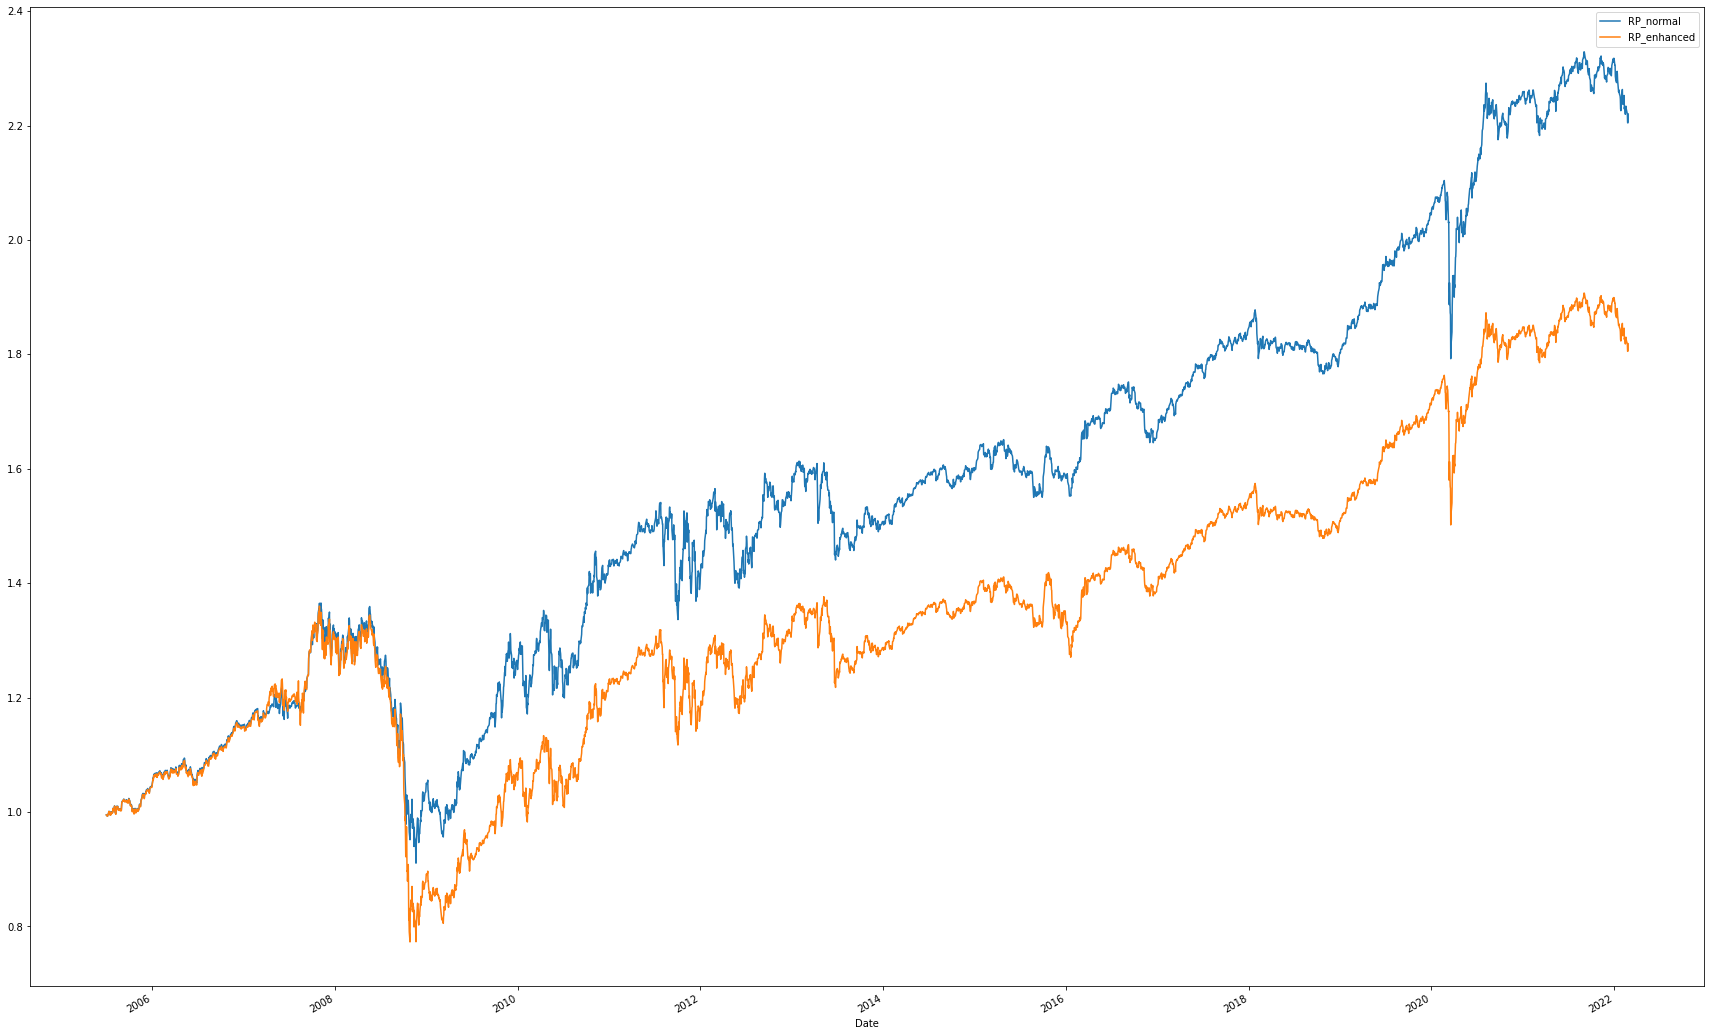

In [138]:
df.plot(figsize=(30,20))

In [5]:
def calc_rc(cov, w):
    rc = (cov @ w) * w
    var = w.T @ cov @ w
    return rc/var

In [7]:
d = {'12':12, '1233':324}

In [8]:
len(d)

2